# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [ ]:
pip install torch_geometric

In [1]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

In [2]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [3]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

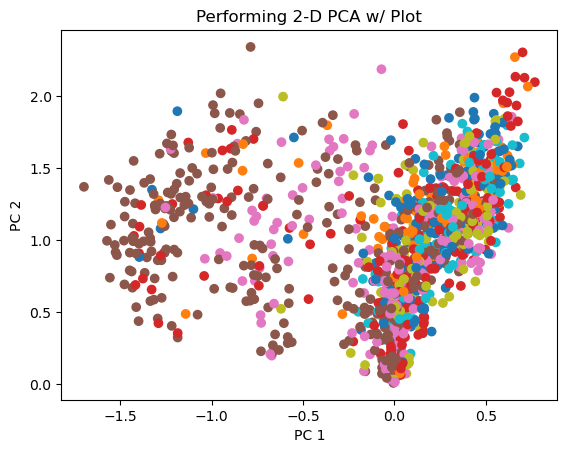

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

viz_dataset = Planetoid(root='/tmp/Cora', name='Cora', split = 'full')
data = pd.DataFrame(viz_dataset.x[viz_dataset.train_mask])
data['y'] = viz_dataset.y[viz_dataset.train_mask]

X_cols = [col for col in data.columns if col != 'y']
n = data.shape[0]
C = (1/n) * (data[X_cols].T @ data[X_cols])
evals, evects = np.linalg.eigh(C)
evects = evects.T
top_2 = evects[-2:].T
pca_train = data[X_cols] @ top_2
data['eig1'], data['eig2'] = pca_train[0], pca_train[1]
plt.scatter(data['eig1'], data['eig2'], c = data['y'], cmap = plt.get_cmap(f"tab10"))
plt.title('Performing 2-D PCA w/ Plot')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [5]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

* **Question 2 (1 pt):** What's "weight decay"?

Weight decay is used in regularization to help decrease overfitting of model on the training data by accounting for the fact that the model is being trained on training data and hence has an implicit bias associate with it. Adding in the weight decay is supposed to take away some of the bias that the model is going to have by minimizing the loss function with a cost by the optimzer.

In [6]:
# Defining a training step
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [7]:
# Run one iteration
train()
acc = test()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5530


/home/vvenkatesh/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.658
Accuracy on epoch 2: 0.676
Accuracy on epoch 3: 0.694
Accuracy on epoch 4: 0.7
Accuracy on epoch 5: 0.7
Accuracy on epoch 6: 0.702
Accuracy on epoch 7: 0.704
Accuracy on epoch 8: 0.702
Accuracy on epoch 9: 0.705
Accuracy on epoch 10: 0.704
Accuracy on epoch 11: 0.711
Accuracy on epoch 12: 0.711
Accuracy on epoch 13: 0.708
Accuracy on epoch 14: 0.708
Accuracy on epoch 15: 0.709
Accuracy on epoch 16: 0.707
Accuracy on epoch 17: 0.702
Accuracy on epoch 18: 0.703
Accuracy on epoch 19: 0.703
Accuracy on epoch 20: 0.702
Accuracy on epoch 21: 0.703
Accuracy on epoch 22: 0.704
Accuracy on epoch 23: 0.706
Accuracy on epoch 24: 0.704
Accuracy on epoch 25: 0.706
Accuracy on epoch 26: 0.706
Accuracy on epoch 27: 0.707
Accuracy on epoch 28: 0.706
Accuracy on epoch 29: 0.709
Accuracy on epoch 30: 0.709
Accuracy on epoch 31: 0.712
Accuracy on epoch 32: 0.711
Accuracy on epoch 33: 0.71
Accuracy on epoch 34: 0.707
Accuracy on epoch 35: 0.707
Accuracy on epoch 36: 0.705
Accura

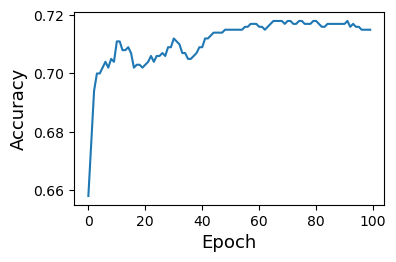

In [9]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


Good luck! :)

**Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

As mentioned during lecture, I will make a confusion matrix and conduct analysis on it to see how accurately GraphSAGE is able to predict classes.

In [10]:
from sklearn import metrics

with torch.no_grad():
    preds = model(dataset.data)[dataset.data.test_mask].argmax(1)
    actual = dataset.data.y[dataset.data.test_mask]

confusion_matrix = metrics.confusion_matrix(actual, preds)
confusion_matrix

/home/vvenkatesh/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


array([[ 94,   6,   1,   7,   9,   7,   6],
       [  5,  78,   2,   3,   0,   2,   1],
       [  3,   8, 117,   5,   1,   2,   8],
       [ 24,  29,   6, 196,  39,  16,   9],
       [  8,   3,   3,  10, 118,   5,   2],
       [  9,   6,   4,   3,   0,  73,   8],
       [  9,   2,   0,   3,   3,   8,  39]])

In [11]:
total_correct = np.diag(confusion_matrix).sum()
print(f"Overall test accuracy: {total_correct/1000}\n")

mistakes_dict = {}
for i in range(min(actual), max(actual) + 1):
    sum_mistakes = 0
    for j in range(7):
        if i != j:
            sum_mistakes += confusion_matrix[i][j]
    mistakes_dict[i] = round(1 - (sum_mistakes / (sum_mistakes + confusion_matrix[i][i])), 2)
print(f"Accuracy by class {mistakes_dict}\n")

print(f"Class accuracy worse than overall: {(list(mistakes_dict.values()) < (total_correct/1000)).sum()}")
print(f"Class accuracy better than overall: {(list(mistakes_dict.values()) >= (total_correct/1000)).sum()}")

Overall test accuracy: 0.715

Accuracy by class {0: 0.72, 1: 0.86, 2: 0.81, 3: 0.61, 4: 0.79, 5: 0.71, 6: 0.61}

Class accuracy worse than overall: 3
Class accuracy better than overall: 4



Based on the results of the conusion matrix above, the model did fairly average at predicting classes equally well. I took the confusion matrix outputted two cells above and did a quick analysis in the cell right above. Based off these results, we see that the model accuracy by class was worse than the overall test accuracy for 3 classes and better for 4 classes, based on the weighted proportion of samples in each class. With regards to the amount of testing data, class 3 and 6 perform a lot worse both at around 61%. 

**Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

When comparing the current GraphSage model with that from the GCN model trained on the Planetoid data in A2, I can conclude that GraphSage performs slightly worse than the GCN model. GraphSage currently is at around 71% accuracy, meanwhile the best GCN model comes in at around 79%. This is probably due to the probability and sampling step included in the GraphSage algorithm which results in a less accurate model since not all of the information from the graph is being captured.

**Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

To do this, I looked into the GraphSage documention and came across the documentation for SAGEConv where I saw the parameter to tune called 'agg' and saw that the default is 'mean'. I changed this to 'max' and retrained the model, the results are below

In [12]:
# model definition
class GraphSAGE_max(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr = 'max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE_max(dataset.num_node_features, dataset.num_classes)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/home/vvenkatesh/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.464
Accuracy on epoch 2: 0.621
Accuracy on epoch 3: 0.697
Accuracy on epoch 4: 0.712
Accuracy on epoch 5: 0.717
Accuracy on epoch 6: 0.725
Accuracy on epoch 7: 0.725
Accuracy on epoch 8: 0.723
Accuracy on epoch 9: 0.724
Accuracy on epoch 10: 0.722
Accuracy on epoch 11: 0.721
Accuracy on epoch 12: 0.718
Accuracy on epoch 13: 0.717
Accuracy on epoch 14: 0.717
Accuracy on epoch 15: 0.714
Accuracy on epoch 16: 0.714
Accuracy on epoch 17: 0.714
Accuracy on epoch 18: 0.713
Accuracy on epoch 19: 0.711
Accuracy on epoch 20: 0.711
Accuracy on epoch 21: 0.71
Accuracy on epoch 22: 0.708
Accuracy on epoch 23: 0.706
Accuracy on epoch 24: 0.705
Accuracy on epoch 25: 0.705
Accuracy on epoch 26: 0.704
Accuracy on epoch 27: 0.704
Accuracy on epoch 28: 0.704
Accuracy on epoch 29: 0.704
Accuracy on epoch 30: 0.704
Accuracy on epoch 31: 0.704
Accuracy on epoch 32: 0.703
Accuracy on epoch 33: 0.703
Accuracy on epoch 34: 0.703
Accuracy on epoch 35: 0.704
Accuracy on epoch 36: 0.705
Ac

In the above model, I changed the aggregation function in the GraphSage class to max, the default is mean. What this means is that at each sampling step, the max of the node's neighbors will be taken instead of the mean, which like mentioned is the default statistic. After training the model on this new change, the overall accuracy is very similar just slightly more with the max by a percentage, from 0.715 to 0.725. 

**Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

To investigate the performance change, I will add a hidden layer of size 700, roughly half of the size of the number of node features and add a ReLU activation function to the hidden layer. I will then compare the performance of this model on the test set with the performance of the initial model with all of the same parameters, but just one layer. 

In [13]:
# model definition
class GraphSAGE_2layer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_channels = 700
        self.conv = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE_2layer(dataset.num_node_features, dataset.num_classes)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.724
Accuracy on epoch 2: 0.781
Accuracy on epoch 3: 0.794
Accuracy on epoch 4: 0.786
Accuracy on epoch 5: 0.781
Accuracy on epoch 6: 0.769
Accuracy on epoch 7: 0.758
Accuracy on epoch 8: 0.747
Accuracy on epoch 9: 0.738
Accuracy on epoch 10: 0.734
Accuracy on epoch 11: 0.73
Accuracy on epoch 12: 0.726
Accuracy on epoch 13: 0.723
Accuracy on epoch 14: 0.725
Accuracy on epoch 15: 0.722
Accuracy on epoch 16: 0.72
Accuracy on epoch 17: 0.721
Accuracy on epoch 18: 0.722
Accuracy on epoch 19: 0.728
Accuracy on epoch 20: 0.727
Accuracy on epoch 21: 0.737
Accuracy on epoch 22: 0.747
Accuracy on epoch 23: 0.756
Accuracy on epoch 24: 0.762
Accuracy on epoch 25: 0.773
Accuracy on epoch 26: 0.776
Accuracy on epoch 27: 0.778
Accuracy on epoch 28: 0.78
Accuracy on epoch 29: 0.783
Accuracy on epoch 30: 0.783
Accuracy on epoch 31: 0.78
Accuracy on epoch 32: 0.772
Accuracy on epoch 33: 0.771
Accuracy on epoch 34: 0.773
Accuracy on epoch 35: 0.769
Accuracy on epoch 36: 0.777
Accur

By adding a hidden layer, you can clearly see that the accuracy has gone up by over almost 9%. The initial model had an accuracy of 71.5 while the model with 2 layers had an accuracy of 80%. This increase is due to adding a hidden layer that allows the model to learn more intricies of the data by segmenting the data once more to process at a higher level. 

**Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

To test this, I will add a drop-out regularization to this network the same way we did in A1. Then, I will make a confusion matrix and analyze accuracy by class. This will help me see what will happen to the ROC curve. 

In [14]:
# model definition
class GraphSAGE_dropout(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        hidden_channels = 700
        dropout_rate = 0.3
        self.conv = SAGEConv(in_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GraphSAGE_dropout(dataset.num_node_features, dataset.num_classes)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.764
Accuracy on epoch 2: 0.784
Accuracy on epoch 3: 0.783
Accuracy on epoch 4: 0.782
Accuracy on epoch 5: 0.783
Accuracy on epoch 6: 0.784
Accuracy on epoch 7: 0.785
Accuracy on epoch 8: 0.787
Accuracy on epoch 9: 0.791
Accuracy on epoch 10: 0.791
Accuracy on epoch 11: 0.793
Accuracy on epoch 12: 0.792
Accuracy on epoch 13: 0.788
Accuracy on epoch 14: 0.786
Accuracy on epoch 15: 0.785
Accuracy on epoch 16: 0.781
Accuracy on epoch 17: 0.779
Accuracy on epoch 18: 0.779
Accuracy on epoch 19: 0.777
Accuracy on epoch 20: 0.777
Accuracy on epoch 21: 0.776
Accuracy on epoch 22: 0.774
Accuracy on epoch 23: 0.778
Accuracy on epoch 24: 0.775
Accuracy on epoch 25: 0.773
Accuracy on epoch 26: 0.774
Accuracy on epoch 27: 0.772
Accuracy on epoch 28: 0.774
Accuracy on epoch 29: 0.775
Accuracy on epoch 30: 0.775
Accuracy on epoch 31: 0.778
Accuracy on epoch 32: 0.781
Accuracy on epoch 33: 0.783
Accuracy on epoch 34: 0.783
Accuracy on epoch 35: 0.783
Accuracy on epoch 36: 0.783
A

In [15]:
from sklearn import metrics

with torch.no_grad():
    preds = model(dataset.data)[dataset.data.test_mask].argmax(1)
    actual = dataset.data.y[dataset.data.test_mask]

confusion_matrix = metrics.confusion_matrix(actual, preds)
confusion_matrix

array([[ 89,   4,   2,   7,   9,   5,  14],
       [  1,  84,   0,   2,   2,   1,   1],
       [  2,  10, 121,   8,   1,   1,   1],
       [ 13,  12,   3, 228,  43,  10,  10],
       [  2,   1,   0,   9, 131,   5,   1],
       [  5,   1,   4,   1,   0,  79,  13],
       [  3,   1,   0,   1,   0,   3,  56]])

In [16]:
total_correct = np.diag(confusion_matrix).sum()
print(f"Overall test accuracy: {total_correct/1000}\n")

mistakes_dict = {}
for i in range(min(actual), max(actual) + 1):
    sum_mistakes = 0
    for j in range(7):
        if i != j:
            sum_mistakes += confusion_matrix[i][j]
    mistakes_dict[i] = round(1 - (sum_mistakes / (sum_mistakes + confusion_matrix[i][i])), 2)
print(f"Accuracy by class {mistakes_dict}\n")

print(f"Class accuracy worse than overall: {(list(mistakes_dict.values()) < (total_correct/1000)).sum()}")
print(f"Class accuracy better than overall: {(list(mistakes_dict.values()) >= (total_correct/1000)).sum()}")

Overall test accuracy: 0.788

Accuracy by class {0: 0.68, 1: 0.92, 2: 0.84, 3: 0.71, 4: 0.88, 5: 0.77, 6: 0.88}

Class accuracy worse than overall: 3
Class accuracy better than overall: 4


Comparing the two models and their accuracy by class we can see the accuracy for the model with dropout is a lot higher than the model without dropout by around 8%. This means that the true positive rate and true negative rate is higher and in turn is reflected in the ROC curve by an increased shift both upwards and outwards. 

**Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


To do this, I took the same exact code that was given for the Cora dataset and simply changed the dataset from Cora to PubMed, both citation datasets within the larger Planetoid dataset. 

In [17]:
dataset = Planetoid(root='/tmp/pubmed', name='PubMed')

model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Defining a training step
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Processing...
Done!
/home/vvenkatesh/.local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.578
Accuracy on epoch 2: 0.665
Accuracy on epoch 3: 0.679
Accuracy on epoch 4: 0.674
Accuracy on epoch 5: 0.684
Accuracy on epoch 6: 0.697
Accuracy on epoch 7: 0.705
Accuracy on epoch 8: 0.705
Accuracy on epoch 9: 0.708
Accuracy on epoch 10: 0.71
Accuracy on epoch 11: 0.712
Accuracy on epoch 12: 0.713
Accuracy on epoch 13: 0.712
Accuracy on epoch 14: 0.715
Accuracy on epoch 15: 0.716
Accuracy on epoch 16: 0.718
Accuracy on epoch 17: 0.719
Accuracy on epoch 18: 0.721
Accuracy on epoch 19: 0.723
Accuracy on epoch 20: 0.725
Accuracy on epoch 21: 0.724
Accuracy on epoch 22: 0.722
Accuracy on epoch 23: 0.722
Accuracy on epoch 24: 0.722
Accuracy on epoch 25: 0.722
Accuracy on epoch 26: 0.724
Accuracy on epoch 27: 0.724
Accuracy on epoch 28: 0.725
Accuracy on epoch 29: 0.724
Accuracy on epoch 30: 0.726
Accuracy on epoch 31: 0.73
Accuracy on epoch 32: 0.73
Accuracy on epoch 33: 0.729
Accuracy on epoch 34: 0.728
Accuracy on epoch 35: 0.728
Accuracy on epoch 36: 0.731
Accu

The accuracy on the very basic model we trained was around 76%. To increase this, I am going to incorporate both adding a hidden layer and adding dropout to the model to see whether it will improve performance or not!

In [18]:
model = GraphSAGE_dropout(dataset.num_node_features, dataset.num_classes)
optimizer= torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.714
Accuracy on epoch 2: 0.709
Accuracy on epoch 3: 0.719
Accuracy on epoch 4: 0.728
Accuracy on epoch 5: 0.736
Accuracy on epoch 6: 0.746
Accuracy on epoch 7: 0.738
Accuracy on epoch 8: 0.732
Accuracy on epoch 9: 0.735
Accuracy on epoch 10: 0.74
Accuracy on epoch 11: 0.747
Accuracy on epoch 12: 0.749
Accuracy on epoch 13: 0.752
Accuracy on epoch 14: 0.756
Accuracy on epoch 15: 0.76
Accuracy on epoch 16: 0.763
Accuracy on epoch 17: 0.765
Accuracy on epoch 18: 0.765
Accuracy on epoch 19: 0.764
Accuracy on epoch 20: 0.765
Accuracy on epoch 21: 0.767
Accuracy on epoch 22: 0.769
Accuracy on epoch 23: 0.77
Accuracy on epoch 24: 0.766
Accuracy on epoch 25: 0.77
Accuracy on epoch 26: 0.773
Accuracy on epoch 27: 0.772
Accuracy on epoch 28: 0.769
Accuracy on epoch 29: 0.758
Accuracy on epoch 30: 0.765
Accuracy on epoch 31: 0.767
Accuracy on epoch 32: 0.769
Accuracy on epoch 33: 0.767
Accuracy on epoch 34: 0.76
Accuracy on epoch 35: 0.76
Accuracy on epoch 36: 0.762
Accurac

Adding in both hidden layers and dropout increase the accuracy by a little more than a percent!